In [8]:
import pandas as pd
import seaborn as sns
import os
import matplotlib.pyplot as plt

from matplotlib.colors import ListedColormap

import warnings
warnings.filterwarnings('ignore')

data = pd.read_csv(r'D:\udacity DS\survey_results_public.csv')

In [10]:
# Filter the data so it only contains the survey result by the developer
developer_data = data[data['MainBranch'] == 'I am a developer by profession']

# Substitute N/A values in JobSat column with the modeof data
developer_data['JobSat'] = developer_data['JobSat'].fillna(developer_data['JobSat'].mode()[0])

# Fill the N/A values in ConvertedComp column with the mean of each country
salary_per_country = developer_data.groupby('Country')['ConvertedComp'].mean()
developer_data['ConvertedComp'] = developer_data.apply(lambda x: salary_per_country[x['Country']] if pd.isnull(x['ConvertedComp']) else x['ConvertedComp'], axis=1)
developer_data = developer_data.dropna(subset=['ConvertedComp'])

# Set the JobSat and OpenSourcerr column into categorical data type so it will be sorted with the right order (ordinal data)
developer_data['JobSat'] = pd.Categorical(developer_data['JobSat'], categories=['Very dissatisfied',
                                                                                'Slightly dissatisfied',
                                                                                'Neither satisfied nor dissatisfied',
                                                                                'Slightly satisfied',
                                                                                'Very satisfied'], ordered=True)

developer_data['OpenSourcer'] = pd.Categorical(developer_data['OpenSourcer'], categories=['Never',
                                                                                'Less than once per year',
                                                                                'Less than once a month but more than once per year',
                                                                                'Once a month or more often'], ordered=True)

In [11]:
# Filtered the data so it only contains the survey result from the top 30 country based on the total respondents
top_30_country = list(developer_data['Country'].value_counts().head(30).index)
filtered_developer_data = developer_data[developer_data['Country'].isin(top_30_country)]

# Aggregate the data so we can visualize it later
aggregated_data = filtered_developer_data.groupby(['Country','JobSat'], as_index=False)['Respondent'].count()

# Add column percentage
total_respondents_per_country = filtered_developer_data['Country'].value_counts()

aggregated_data['Respondent Percentage'] = aggregated_data \
                                           .apply(lambda x: x['Respondent'] / total_respondents_per_country[x['Country']], axis=1) \
                                           .round(3)

# Pivot the data
aggregated_data = aggregated_data[['Country', 'JobSat', 'Respondent Percentage']]
pivoted_data = pd.pivot_table(aggregated_data, values='Respondent Percentage', index='Country', columns='JobSat') \
                 .sort_values('Very satisfied', ascending=False)

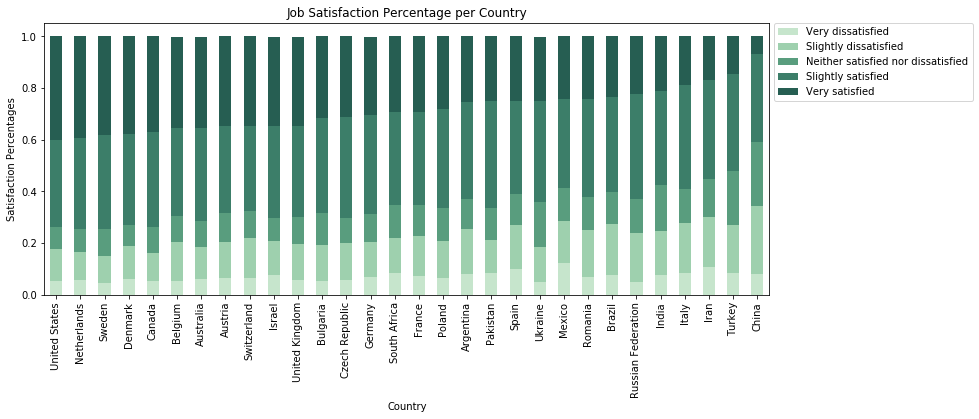

In [12]:
# Visualize the data
pivoted_data.plot(kind='bar', 
                  stacked=True, 
                  colormap=ListedColormap(sns.color_palette("ch:2.5,-.2,dark=.3")),
                  figsize=(13,5))
plt.legend(loc="upper left", bbox_to_anchor=(1,1.02))
plt.ylabel('Satisfaction Percentages')
plt.title('Job Satisfaction Percentage per Country')
plt.show()

In [14]:
# Create a new columns to flag each respondent if their major is related or not
def ITorNot(value):
    '''
    input: the value of each row in the selected column
    output: the mapped value based on the rule we made in this function
    '''

    if value == 'Computer science, computer engineering, or software engineering' \
    or value == 'Information systems, information technology, or system administration' \
    or value == 'Web development or web design':
        return 'IT Background'
    return 'Non IT Background'

developer_data['Major'] = developer_data['UndergradMajor'].apply(ITorNot)

developer_data['Major'].value_counts(normalize=True)

IT Background        0.708178
Non IT Background    0.291822
Name: Major, dtype: float64

In [15]:
# Aggregate the data so we know how many respondents in each major (IT related or not IT related)
aggregated_data = developer_data.groupby(['Major','JobSat'], as_index=False)['Respondent'].count()

# Add column percentage
total_respondents_per_major = developer_data['Major'].value_counts()

aggregated_data['Respondent Percentage'] = aggregated_data \
                                           .apply(lambda x: x['Respondent'] / total_respondents_per_major[x['Major']], axis=1) \
                                           .round(4)

# Pivot the data
aggregated_data = aggregated_data[['Major', 'JobSat', 'Respondent Percentage']]
pivoted_data = pd.pivot_table(aggregated_data, values='Respondent Percentage', index='Major', columns='JobSat')

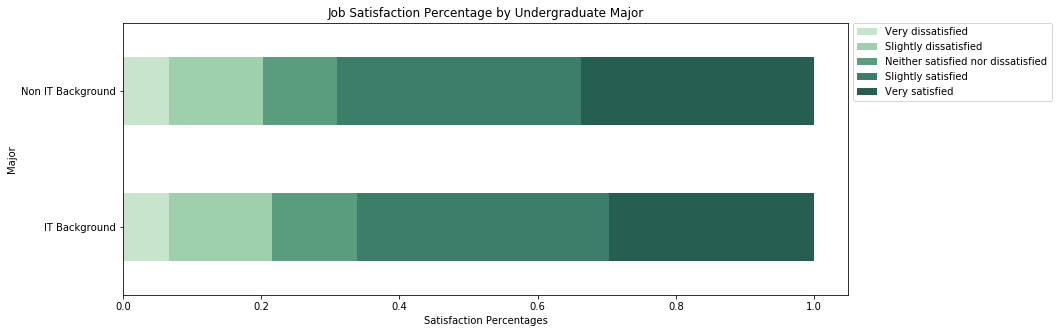

In [16]:
# Visualize the data
pivoted_data.plot(kind='barh', 
                  stacked=True, 
                  colormap=ListedColormap(sns.color_palette("ch:2.5,-.2,dark=.3")),
                  figsize=(13,5))
plt.legend(loc="upper left", bbox_to_anchor=(1,1.02))
plt.xlabel('Satisfaction Percentages')
plt.title('Job Satisfaction Percentage by Undergraduate Major')
plt.show()

In [17]:
pivoted_data

JobSat,Very dissatisfied,Slightly dissatisfied,Neither satisfied nor dissatisfied,Slightly satisfied,Very satisfied
Major,,,,,
IT Background,0.0661,0.1493,0.1239,0.3641,0.2966
Non IT Background,0.0664,0.1363,0.1070,0.3527,0.3376


In [18]:
# Aggregate the data
comp_per_category = developer_data.groupby('OpenSourcer', as_index=False)['ConvertedComp'].mean()

comp_per_category

,OpenSourcer,ConvertedComp
0,Never,117254.369170
1,Less than once per year,120802.882927
2,Less than once a month but more than once per ...,123194.248789
3,Once a month or more often,123881.913894


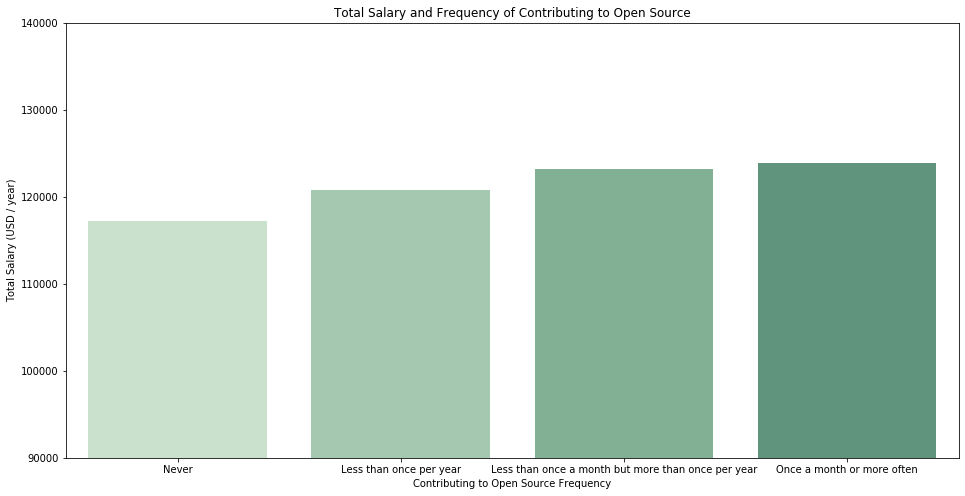

In [19]:
# Visualize the data
plt.figure(figsize=(16, 8))
sns.barplot(data=comp_per_category, x='OpenSourcer', y='ConvertedComp', palette=sns.color_palette("ch:2.5,-.2,dark=.3"))
plt.ylim(90000,140000)
plt.title('Total Salary and Frequency of Contributing to Open Source')
plt.ylabel('Total Salary (USD / year)')
plt.xlabel('Contributing to Open Source Frequency')
plt.show()